In [2]:
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np
import random
from collections import Counter
import copy
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_clean = pd.read_csv('data_emotion_clean.csv', encoding='latin1')
data_clean.head()

,Customer Review,Sentiment,Emotion
0,alhamdulillah fungsi packaging aman respon cep...,Positive,Happy
1,barang bagus respon cepat harga saing yg,Positive,Happy
2,barang bagus fungsi seler ramah kirim cepat,Positive,Happy
3,bagus sesuai harap jual nya ramah trimakasih l...,Positive,Happy
4,barang bagus emas aman fungsi,Positive,Happy


In [4]:
data_cleans = data_clean['Customer Review'].astype('U')
emosi_cleans = data_clean['Emotion'].astype('U')
num_rows = len(data_clean)

list_kata = {}
list_emosi = []
kelas_emosi = []

In [5]:
def masukkan_ke_dictionary(kalimat, ke):
    for kata in kalimat:
        tf = kalimat.count(kata)
        if kata not in list_kata:
            list_kata[kata] = []
            list_kata[kata].append(ke)
        elif ke not in list_kata[kata]:
            list_kata[kata].append(ke)

for ke, kalimat in enumerate(data_cleans):
    tokens = word_tokenize(kalimat)
    masukkan_ke_dictionary(tokens, ke)

In [6]:
def masukkan_ke_dictionary_emosi(emosi,ke):
    list_emosi.append([ke,emosi])

for ke, emosi in enumerate(emosi_cleans):
    masukkan_ke_dictionary_emosi(emosi,ke)
    if emosi not in kelas_emosi:
        kelas_emosi.append(emosi)

In [7]:
kelas_emosi = sorted(kelas_emosi)
print(len(list_kata.get("amanah", [])))
print(kelas_emosi)

40
['Anger', 'Fear', 'Happy', 'Love', 'Sadness']


# TF-IDF

In [8]:
def hitung_tf(kalimat):
    panjang = len(kalimat)
    data_list_unique = list(set(kalimat))
    list_tf = []
    for kata in data_list_unique:
        tf = kalimat.count(kata) / panjang
        list_tf.append([kata, tf])
    return list_tf
def hitung_idf(kalimat):
    data_list_unique = list(set(kalimat))
    list_idf = []
    for kata in data_list_unique:
        dokumen_berisi_kata = len(list_kata.get(kata, []))
        hitung = np.log((num_rows) / ((dokumen_berisi_kata)+1))
        list_idf.append([kata,hitung])
    return list_idf
def hitung_tf_idf(hasil_tf,hasil_idf):
    list_tf_idf = []
    for i in range(len(hasil_tf)):
        hasil = hasil_tf[i][1]*hasil_idf[i][1]
        list_tf_idf.append([hasil_tf[i][0],hasil])
    return list_tf_idf

In [9]:
hasil_tf_idf = {}
for ke,kalimat in enumerate(data_cleans):
    list_tf = hitung_tf(word_tokenize(kalimat))
    list_idf = hitung_idf(word_tokenize(kalimat))
    tf_idf = hitung_tf_idf(list_tf,list_idf)
    print(tf_idf)
    hasil_tf_idf[ke] = tf_idf

[['packaging', 0.356371631115993], ['aman', 0.26672282065819547], ['kurir', 0.4050859450282362], ['respon', 0.2710831844064087], ['amanah', 0.48805821658480586], ['alhamdulillah', 0.47440066308423073], ['cepat', 0.199292411382349], ['fungsi', 0.3010657923770667], ['seller', 0.24308394285177248], ['ramah', 0.3537908427204058]]
[['bagus', 0.2749508775277838], ['barang', 0.18232543341798146], ['saing', 0.8408720044928794], ['yg', 0.26279287615205765], ['respon', 0.3872616920091552], ['harga', 0.363488682474344], ['cepat', 0.28470344483192705]]
[['bagus', 0.2749508775277838], ['seler', 0.8851798513934279], ['barang', 0.18232543341798146], ['cepat', 0.28470344483192705], ['kirim', 0.2076715984930296], ['fungsi', 0.4300939891100952], ['ramah', 0.5054154896005797]]
[['bagus', 0.24058201783681082], ['sesuai', 0.20649969085661204], ['lapak', 0.7536506093863536], ['harap', 0.5852664033905275], ['trimakasih', 0.78644614244479], ['nya', 0.24843800579426878], ['jual', 0.32978960788594186], ['ramah'

In [10]:
print(hasil_tf_idf[3621])

[['pakai', 0.434617037877988], ['packaging', 0.593952718526655], ['aman', 0.4445380344303258], ['tekstur', 1.0182079304607274], ['gampang', 0.6999508463133212], ['creamy', 1.3168345086654032]]


# Pembagian Data

In [11]:
## Hitung Jumlah data testing yang dibutuhkan
def ukuran_test(testing_data):
    jumlah_testing_data = {}
    for emosi in list_emosi:
        if emosi[1] not in jumlah_testing_data:
            jumlah_testing_data[emosi[1]] = 1
        else:
            jumlah_testing_data[emosi[1]] += 1
    total_testing = 0
    for key in jumlah_testing_data:
        td = round(jumlah_testing_data[key] * testing_data / 100)
        jumlah_testing_data[key] = td
        total_testing += td
    return jumlah_testing_data, total_testing

In [12]:
def pemecahan_data(list_emosi, total_testing):
    list_testing_data = {}
    list_testing_emosi = []
    random.shuffle(list_emosi)
    while True:
        if total_testing[1] == len(list_testing_emosi):
            break
        random_index, random_element = random.choice(list(enumerate(list_emosi)))
        if total_testing[0][random_element[1]] != 0:
            list_testing_emosi.append(random_element)
            list_testing_data[random_element[0]] = hasil_tf_idf[random_element[0]]
            total_testing[0][random_element[1]] -= 1
            list_emosi.remove(random_element)
            del hasil_tf_idf[random_element[0]]
    return list_testing_data, list_testing_emosi, hasil_tf_idf, list_emosi

In [13]:
## Pembagian data training dan testing
testing_data = 30   #input in percentage
ukuran = ukuran_test(testing_data)
x_test, y_test, x_train, y_train = pemecahan_data(list_emosi,ukuran)

print(x_test)
print(y_test)

{3727: [['kecewaaa', 7.2078598714324755]], 306: [['barang', 0.12762780339258703], ['musik', 0.6802394763324311], ['ga', 0.23977101047578453], ['bocor', 0.4983236319908142], ['kecewa', 0.23326625482313235], ['jg', 0.36963144326014546], ['packing', 0.2727686175619069], ['baret', 0.6196258959753996], ['kotor', 0.495656807282598], ['jalan', 0.48805821658480586]], 5338: [['produk', 0.12239124874417343], ['jgn', 0.247828403641299], ['bagus', 0.09623280713472433], ['pake', 0.1729177897751052], ['jam', 0.2052758931410113], ['instant', 0.2943052015725078], ['sampe', 0.1946836933379975], ['kualitas', 0.12988510719666724], ['instan', 0.2943052015725078], ['bener', 0.44832803683790545], ['sen', 0.20471722811110504], ['mantul', 0.270805020110221], ['bgt', 0.17033842133558055], ['cepet', 0.40298060410845293], ['emas', 0.22499048351651327], ['banget', 0.11927821032278685], ['kirim', 0.07268505947256036], ['ragu', 0.2729330008311608]], 2700: [['d', 0.32897431684738887], ['check', 0.46994212175110506],

In [14]:
## Hasil pembagian data testing

list_kata_training = []
for value in x_train.values():
    for kata in value:
        if kata[0] not in list_kata_training:
            list_kata_training.append(kata[0])
emotion_counter = Counter()
for _, emotion in y_train:
    emotion_counter[emotion] += 1
pembagian_emosi_training = {emotion: emotion_counter[emotion] for emotion in kelas_emosi}
for emotion, count in pembagian_emosi_training.items():
    print(f"{emotion}: {count}")

Anger: 489
Fear: 644
Happy: 1239
Love: 566
Sadness: 841


# Training

In [15]:
def kata_setiap_kelas(kelas):
    total = 0
    values = [number for number, emotion in y_train if emotion == kelas]
    for kunci in values:
        total += len(x_train[kunci])
    return total, values

def kata_tertentu_setiap_kelas(isi,dokumens,kata):
    total = 0
    for dokumen in dokumens:
        if dokumen in isi:
            for kata_dokumen in x_train[dokumen]:
                if kata_dokumen[0] == kata:
                    total += kata_dokumen[1]
    return total

In [16]:
probabilitas_kelas = {}

def training_mnb():
    list_dokumen_berdasarkan_kelas = {}
    jumlah_kata_setiap_kelas = {}
    peluang_kata_tertentu_setiap_kelas = {}

    for number, emotion in y_test:
        if emotion not in jumlah_kata_setiap_kelas:
            jumlah_kata_setiap_kelas[emotion] = []

    for emotion, count in pembagian_emosi_training.items():
        probabilitas_kelas[emotion] = count/len(y_train)

    for key in jumlah_kata_setiap_kelas:
        dokumen_setiap_kelas = kata_setiap_kelas(key)
        list_dokumen_berdasarkan_kelas[key] = dokumen_setiap_kelas[1]
        jumlah_kata_setiap_kelas[key].append(dokumen_setiap_kelas[0])

    for kata, isi in list_kata.items():
        for key,dokumen in list_dokumen_berdasarkan_kelas.items():
            jumlah_kata = kata_tertentu_setiap_kelas(isi,dokumen,kata)+1
            hasil_peluang = jumlah_kata/(jumlah_kata_setiap_kelas[key][0]+len(list_kata_training))
            if kata not in peluang_kata_tertentu_setiap_kelas:
                peluang_kata_tertentu_setiap_kelas[kata] = []
                peluang_kata_tertentu_setiap_kelas[kata].append([key,hasil_peluang])
            else:
                peluang_kata_tertentu_setiap_kelas[kata].append([key,hasil_peluang])

    return peluang_kata_tertentu_setiap_kelas

# Testing

In [17]:
## Klasifikasi data testing terhadap data training

def klasifikasi_mnb(dokumen, peluang_kata):
    hasil_setiap_kelas = {}
    for key, hasil_probabilitas in probabilitas_kelas.items():
        hitung = 1
        for kata in dokumen:
            for kelas_emosi in peluang_kata[kata[0]]:
                if kelas_emosi[0] == key:
                    hitung *= kelas_emosi[1]
        hasil = hitung * hasil_probabilitas
        hasil_setiap_kelas[key] = hasil
    return hasil_setiap_kelas


In [18]:
def testing_mnb(peluang_kata):
    hasil_testing = {}
    for key,value in x_test.items():
        hasil_klasifikasi = klasifikasi_mnb(value, peluang_kata)
        hasil_testing[key] = hasil_klasifikasi
    return hasil_testing

In [19]:
## Kelas yang didapatkan setelah testing

def hasil_klasifikasi(hasil_testing):
    hasil = {}
    for key, values in hasil_testing.items():
        highest_emotion = max(values, key=values.get)
        hasil[key] = highest_emotion
    return hasil

In [20]:
train_mnb = training_mnb()

testing_data = testing_mnb(train_mnb)

hasil_klasifikasi_data = hasil_klasifikasi(testing_data)

print(hasil_klasifikasi_data)
print(len(hasil_klasifikasi_data))

{3727: 'Sadness', 306: 'Sadness', 5338: 'Happy', 2700: 'Sadness', 3507: 'Happy', 3085: 'Happy', 4133: 'Fear', 4397: 'Happy', 376: 'Fear', 4997: 'Anger', 2272: 'Happy', 3374: 'Fear', 3456: 'Happy', 3577: 'Happy', 4723: 'Fear', 3685: 'Anger', 418: 'Happy', 1780: 'Happy', 1733: 'Love', 468: 'Sadness', 5125: 'Sadness', 3634: 'Happy', 1328: 'Happy', 4260: 'Happy', 3959: 'Sadness', 3846: 'Sadness', 1402: 'Love', 4989: 'Anger', 5360: 'Happy', 990: 'Sadness', 1076: 'Sadness', 1026: 'Happy', 157: 'Love', 4211: 'Happy', 4658: 'Happy', 2498: 'Happy', 1727: 'Love', 4844: 'Happy', 3714: 'Fear', 3414: 'Love', 3429: 'Happy', 833: 'Happy', 4843: 'Happy', 893: 'Sadness', 379: 'Anger', 3353: 'Sadness', 2170: 'Sadness', 4393: 'Love', 1478: 'Fear', 1200: 'Happy', 1627: 'Happy', 38: 'Happy', 506: 'Fear', 696: 'Anger', 2948: 'Happy', 2379: 'Happy', 931: 'Happy', 1078: 'Sadness', 1625: 'Happy', 4149: 'Sadness', 4722: 'Happy', 2000: 'Happy', 3758: 'Sadness', 3689: 'Anger', 2913: 'Love', 4550: 'Happy', 642: 'H

# Confusion Matrix

In [21]:
print(hasil_klasifikasi_data)
print(y_test)
array_5x5 = np.zeros((len(kelas_emosi), len(kelas_emosi)))
for isi_list in y_test:
    if isi_list[1] == hasil_klasifikasi_data[isi_list[0]]:
        ke = kelas_emosi.index(isi_list[1])
        array_5x5[ke][ke] += 1
    elif isi_list[1] != hasil_klasifikasi_data[isi_list[0]]:
        ke_actual = kelas_emosi.index(isi_list[1])
        ke_prediction = kelas_emosi.index(hasil_klasifikasi_data[isi_list[0]])
        array_5x5[ke_actual][ke_prediction] += 1
print(array_5x5)

{3727: 'Sadness', 306: 'Sadness', 5338: 'Happy', 2700: 'Sadness', 3507: 'Happy', 3085: 'Happy', 4133: 'Fear', 4397: 'Happy', 376: 'Fear', 4997: 'Anger', 2272: 'Happy', 3374: 'Fear', 3456: 'Happy', 3577: 'Happy', 4723: 'Fear', 3685: 'Anger', 418: 'Happy', 1780: 'Happy', 1733: 'Love', 468: 'Sadness', 5125: 'Sadness', 3634: 'Happy', 1328: 'Happy', 4260: 'Happy', 3959: 'Sadness', 3846: 'Sadness', 1402: 'Love', 4989: 'Anger', 5360: 'Happy', 990: 'Sadness', 1076: 'Sadness', 1026: 'Happy', 157: 'Love', 4211: 'Happy', 4658: 'Happy', 2498: 'Happy', 1727: 'Love', 4844: 'Happy', 3714: 'Fear', 3414: 'Love', 3429: 'Happy', 833: 'Happy', 4843: 'Happy', 893: 'Sadness', 379: 'Anger', 3353: 'Sadness', 2170: 'Sadness', 4393: 'Love', 1478: 'Fear', 1200: 'Happy', 1627: 'Happy', 38: 'Happy', 506: 'Fear', 696: 'Anger', 2948: 'Happy', 2379: 'Happy', 931: 'Happy', 1078: 'Sadness', 1625: 'Happy', 4149: 'Sadness', 4722: 'Happy', 2000: 'Happy', 3758: 'Sadness', 3689: 'Anger', 2913: 'Love', 4550: 'Happy', 642: 'H

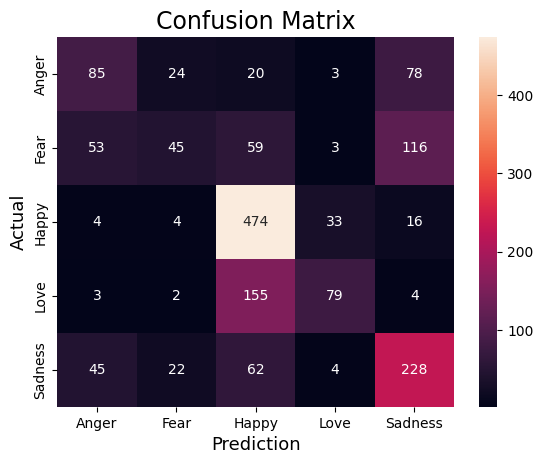

In [22]:
sns.heatmap(array_5x5,
            annot=True,
            fmt='g',
            xticklabels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'],
            yticklabels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'])
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

In [23]:
def accuracy_score(true_positives):
    total = 0
    for val in true_positives:
        total += val
    return total/ukuran[1]

def precision_score(true_positives,false_positives):
    total = 0
    for i in range(len(true_positives)):
        total += true_positives[i]/(true_positives[i]+false_positives[i])
    return total/len(true_positives)

def recall_score(true_positives, false_negatives):
    total = 0
    for i in range(len(true_positives)):
        total += true_positives[i]/(true_positives[i]+false_negatives[i])
    return total/len(true_positives)


In [24]:
true_positives = np.diag(array_5x5)
false_positives = np.sum(array_5x5, axis=0) - true_positives
false_negatives = np.sum(array_5x5, axis=1) - true_positives

print(true_positives)
print(false_positives)
print(false_negatives)

print("Akurasi:", accuracy_score(true_positives))
print("Presisi:", precision_score(true_positives, false_positives))
print("Recall:", recall_score(true_positives, false_negatives))

[ 85.  45. 474.  79. 228.]
[105.  52. 296.  43. 214.]
[125. 231.  57. 164. 133.]
Akurasi: 0.5619987661937076
Presisi: 0.5380496900178396
Recall: 0.483428515656254
